In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import pickle

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from ray_delay.ray_detector import RayDetectorSpec, RayModelType
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
dx = 13
dz = 13
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

In [3]:
ray_radius = 6
ray_qubit = center_qubit

In [4]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [5]:
patch.reset()
baseline_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(ray_qubit, ray_radius)
ray_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

In [6]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

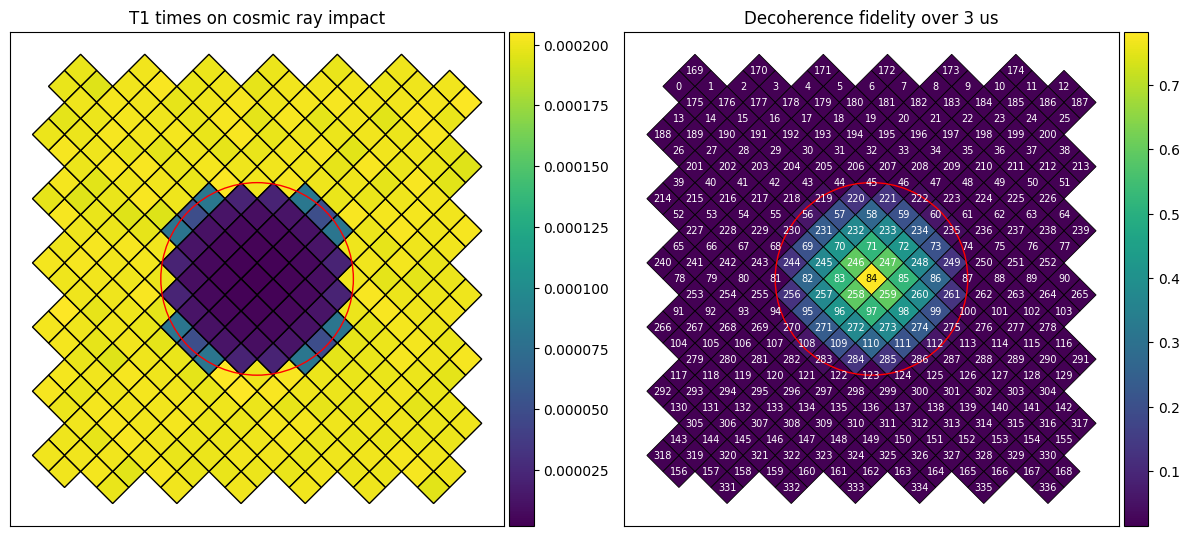

In [7]:
fig,ax = plt.subplots(1,2, figsize=(12,7))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = val
patch.patch.plot_qubit_vals(plot_vals, ax=ax[0], plot_text=None)
ax[0].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
# ax.plot([patch.patch.qubit_name_dict[ray_qubit].coords[1]], [patch.patch.qubit_name_dict[ray_qubit].coords[0]], 'x', color='r')
ax[0].set_title('T1 times on cosmic ray impact')

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = 1 - np.exp(-3e-6/val)
patch.patch.plot_qubit_vals(plot_vals, ax=ax[1], font_size=7)
ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax[1].set_title('Decoherence fidelity over 3 us')

plt.tight_layout()
# plt.savefig('ray_model.png', dpi=300)

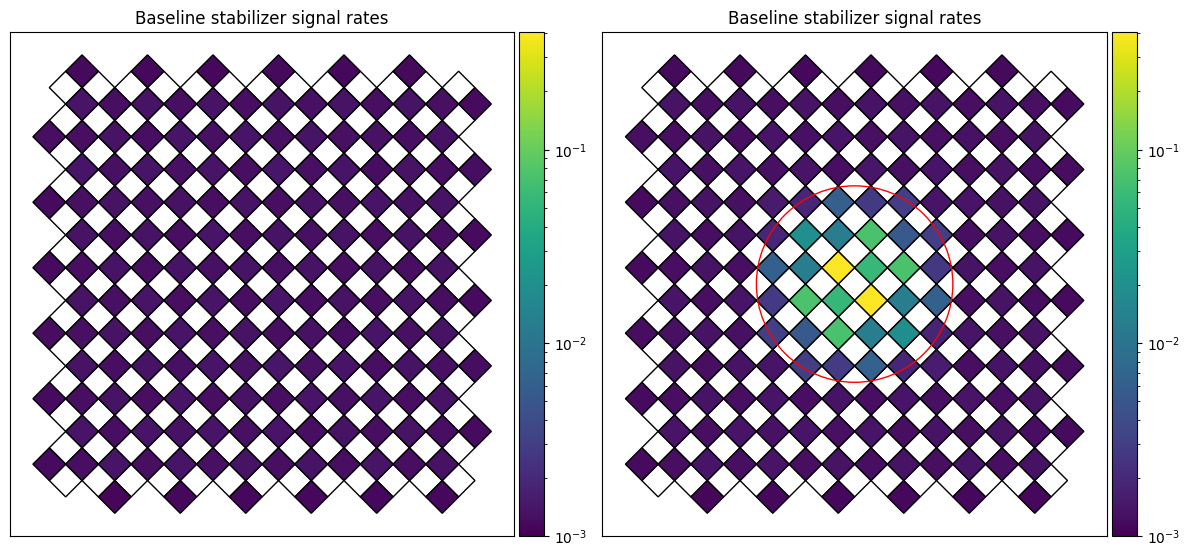

In [8]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-3
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots(1, 2, figsize=(12,6))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = baseline_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[0], plot_text=None, vmin=vmin, vmax=vmax, norm=norm, cmap_name=cmap)
ax[0].set_title('Baseline stabilizer signal rates')
# ax[0].set_title('Baseline error rate: {:.2e}'.format(baseline_err_rate))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[1], plot_text=None, vmin=vmin, vmax=vmax, norm=norm, cmap_name=cmap)
ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax[1].set_title('Baseline stabilizer signal rates')
# for affected_qubit in patch.noise_model.active_cosmic_rays[0].affected_qubits:
    # ax[1].plot([patch.patch.qubit_name_dict[affected_qubit].coords[1]], [patch.patch.qubit_name_dict[affected_qubit].coords[0]], 'x', color='r')
# ax[1].set_title('Ray error rate: {:.2e}'.format(ray_err_rate))

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm(vmin=vmin, vmax=vmax),
# cmap=cmap), cax=cbar_ax)

plt.tight_layout()
# plt.savefig('square_patch_ray.png', dpi=300)

In [9]:
def _initialize_windows(
        device: list[list[Qubit | None]],
        spatial_window_size: int,
        only_full_windows: bool = False,
    ) -> list[list[int]]:
    """Initialize spatial windows that we will use to detect cosmic rays.
    
    Args:
        device: The layout of the device, in the form of a 2D list of Qubit
            objects.
    """
    assert spatial_window_size < len(device) and spatial_window_size < len(device[0])
    window_rows = (len(device) - spatial_window_size)//2 + 1
    window_cols = (len(device[0]) - spatial_window_size)//2 + 1

    min_qubit_count = spatial_window_size**2 if only_full_windows else 1

    all_windows = []
    for wr in range(window_rows):
        for wc in range(window_cols):
            window_qubits = []
            for r in range(wr, wr + spatial_window_size):
                for c in range(wc, wc + spatial_window_size):
                    qb = device[2*r][2*c]
                    if isinstance(qb, MeasureQubit):
                        window_qubits.append(qb.idx)
            if len(window_qubits) >= min_qubit_count:
                all_windows.append(window_qubits)
    return all_windows

In [10]:
mpmath.mp.dps = 50

cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

thresholds = [1-mpmath.mpf(1e-9), 1-mpmath.mpf(1e-10), 1-mpmath.mpf(1e-11), 1-mpmath.mpf(1e-13), 1-mpmath.mpf(1e-15)]
temporal_window_size = 50
spatial_size = 2

detector_windows = _initialize_windows(patch.patch.device, spatial_size, only_full_windows=True)

In [11]:
[1-float(t) for t in thresholds]

[9.999999717180685e-10,
 1.000000082740371e-10,
 1.000000082740371e-11,
 1.000310945187266e-13,
 9.992007221626409e-16]

In [12]:
signal_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=mpmath.mpf)
syndrome_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=float)
false_positive_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=mpmath.mpf)
detection_thresholds = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=int)
for i,threshold in enumerate(thresholds):
    for latency in range(max_latency):
        for k,window in enumerate(detector_windows):
            baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
            ray_mean = np.mean([ray_fractions_labeled[q] for q in window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(float(threshold), len(window)*temporal_window_size, baseline_mean)
            detection_thresholds[i,latency,k] = detection_threshold

            # chance that baseline generates more than threshold detections
            false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, baseline_mean)
            false_positive_rates[i,latency,k] = mpmath.mpf(false_positive)
        
            if latency <= temporal_window_size:
                # some part of window is at baseline rate (before ray has hit)
                windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
            else:
                windowed_syndrome_rate = ray_mean
            syndrome_rates[i,latency,k] = mpmath.mpf(windowed_syndrome_rate)
            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
            signal_rates[i,latency,k] = mpmath.mpf(detection_prob)

cumulative_no_signal_rates = np.cumprod(np.prod(1-signal_rates, axis=2), axis=1)
cumulative_signal_rates = 1 - cumulative_no_signal_rates
cumulative_no_signal_rates_baseline = np.cumprod(np.prod(1-false_positive_rates, axis=2), axis=1)
cumulative_false_positive_rates = 1 - cumulative_no_signal_rates_baseline

In [13]:
qubit_no_signal_rates = np.ones((len(thresholds), max_latency, len(patch.patch.all_qubits)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for latency in range(max_latency):
        for k,window in enumerate(detector_windows):
            signal_rate = signal_rates[i,latency,k]
            for q in window:
                # measure qubit
                qubit_no_signal_rates[i,latency,q] *= (1-signal_rate)
                # data qubits
                # for data_q in patch.patch.qubit_name_dict[q].data_qubits:
                #     if data_q is not None:
                #         qubit_no_signal_rates[i,latency,data_q.idx] *= (1-signal_rate)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x28acce690>)

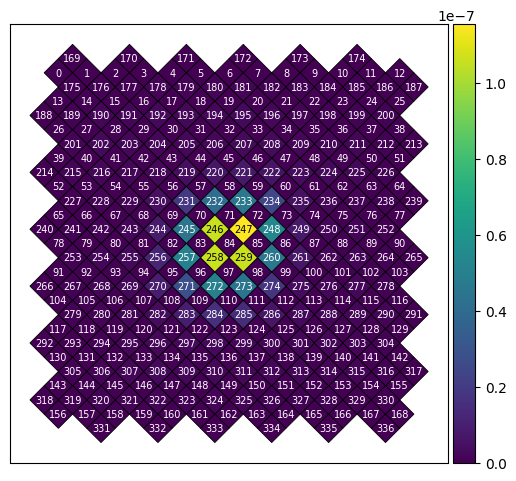

In [14]:
patch.patch.plot_qubit_vals((1-qubit_no_signal_rates[0,1]).astype(float), font_size=7)

In [15]:
distances = np.zeros(len(patch.patch.ancilla), dtype=float)
center_coords = patch.patch.qubit_name_dict[center_qubit].coords

for i,qubit in enumerate(patch.patch.ancilla):
    coords = qubit.coords
    distances[i] = np.sqrt((coords[0]-center_coords[0])**2 + (coords[1]-center_coords[1])**2)

In [16]:
unique_distances = []
qubits_per_distance = []
for i,dst in enumerate(distances):
    qubit = patch.patch.ancilla[i].idx
    dst_rounded = np.round(dst, 2)
    if dst_rounded not in unique_distances:
        unique_distances.append(dst_rounded)
        qubits_per_distance.append([qubit])
    else:
        qubits_per_distance[unique_distances.index(dst_rounded)].append(qubit)

In [17]:
qubits_per_distance = np.array(qubits_per_distance, dtype=object)[np.argsort(unique_distances)]
unique_distances = np.sort(unique_distances)

In [18]:
signal_rate_by_distance = np.zeros((len(thresholds), max_latency, len(unique_distances)), dtype=mpmath.mpf)
for k,dst in enumerate(unique_distances):
    for q in qubits_per_distance[k]:
        signal_rate_by_distance[:,:,k] += (1-qubit_no_signal_rates[:,:,q])
    signal_rate_by_distance[:,:,k] /= len(qubits_per_distance[k])

In [19]:
unique_distances

array([ 1.41,  3.16,  4.24,  5.1 ,  5.83,  7.07,  7.62,  8.6 ,  9.06,
        9.49,  9.9 , 10.3 , 11.05, 11.4 , 12.08, 12.73, 13.04, 13.34,
       13.93, 14.21, 14.76, 15.56, 15.81, 17.03])

In [20]:
for i,threshold in enumerate(thresholds):
    def detection_chance(distance_from_center, cycles_after_ray):
        latency = min(cycles_after_ray, temporal_window_size)
        return np.interp(distance_from_center, unique_distances, signal_rate_by_distance[i,latency].astype(float))
    ray_detector_spec = RayDetectorSpec(
        detector_spatial_window_size = spatial_size,
        detector_temporal_window_size = temporal_window_size,
        ray_model_type = RayModelType.LINEAR_ERR,
        ray_radius = ray_radius,
        ray_max_strength = 0.99,
        detection_chance_function = detection_chance,
    )
    pickle.dump(ray_detector_spec, open(f'detection_chance_functions/linear_err_thresh=1e{int(np.round(np.log10(float(1-threshold))))}.pkl', 'wb'))

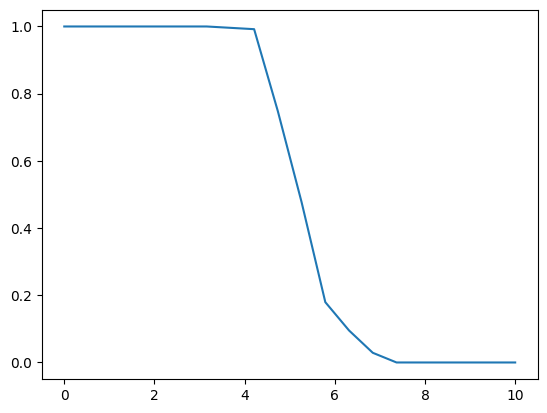

In [21]:
detector_spec = pickle.load(open(f'detection_chance_functions/linear_err_thresh=1e-9.pkl', 'rb'))

# plt.plot(unique_distances, signal_rate_by_distance[-1,-1].T, 'o')
plt.plot(np.linspace(0,10,20), detector_spec.detection_chance_function(np.linspace(0,10,20), -1))

In [22]:
detector_spec.detection_chance_function(np.linspace(0,10,20), 0)

array([1.16573418e-15, 1.16573418e-15, 1.16573418e-15, 1.20056847e-15,
       1.30908651e-15, 1.41760455e-15, 1.52612259e-15, 1.59391668e-15,
       1.66154723e-15, 1.52101913e-15, 1.45585698e-15, 1.58592998e-15,
       1.55788771e-15, 1.51665489e-15, 1.57409970e-15, 1.65703171e-15,
       1.69429752e-15, 1.71744769e-15, 1.62738720e-15, 1.69309011e-15])